In [1]:
%matplotlib inline


====================================================================
Decoding in sensor space data using the Common Spatial Pattern (CSP)
====================================================================

Decoding applied to MEG data in sensor space decomposed using CSP.
Here the classifier is applied to features extracted on CSP filtered signals.

See http://en.wikipedia.org/wiki/Common_spatial_pattern and [1]_.

References
----------

.. [1] Zoltan J. Koles. The quantitative extraction and topographic mapping
       of the abnormal components in the clinical EEG. Electroencephalography
       and Clinical Neurophysiology, 79(6):440--447, December 1991.



In [2]:
# Authors: Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
#          Romain Trachel <romain.trachel@inria.fr>
#
# License: BSD (3-clause)

import numpy as np
import matplotlib.pyplot as plt

import mne
from mne import io
from mne.datasets import sample

print(__doc__)

data_path = sample.data_path()

Automatically created module for IPython interactive environment


Set parameters and read data



In [3]:
raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
event_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif'
tmin, tmax = -0.2, 0.5
event_id = dict(aud_l=1, vis_l=3)

# Setup for reading the raw data
raw = io.read_raw_fif(raw_fname, preload=True)
raw.filter(2, None)  # replace baselining with high-pass
events = mne.read_events(event_fname)

raw.info['bads'] = ['MEG 2443']  # set bad channels
picks = mne.pick_types(raw.info, meg='grad', eeg=False, stim=False, eog=False,
                       exclude='bads')

# Read epochs
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=picks, baseline=None, preload=True)

labels = epochs.events[:, -1]
evoked = epochs.average()

Opening raw data file /home/arasdar/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Current compensation grade : 0
Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Setting up high-pass filter at 2 Hz
l_trans_bandwidth chosen to be 2.0 Hz
Filter length of 496 samples (3.303 sec) selected
145 matching events found
4 projection items activated
Loading data for 145 events and 106 original time points ...
0 bad epochs dropped


In [4]:
raw, events, 
event_id, evoked, evoked.info
epochs, evoked, events.shape, raw.get_data().shape, raw.info

(<Epochs  |  n_events : 145 (all good), tmin : -0.199795213158 (s), tmax : 0.499488032896 (s), baseline : None, ~27.1 MB, data loaded,
  'aud_l': 72, 'vis_l': 73>,
 <Evoked  |  comment : '0.50 * aud_l + 0.50 * vis_l', kind : average, time : [-0.199795, 0.499488], n_epochs : 145, n_channels x n_times : 203 x 106, ~3.5 MB>,
 (319, 3),
 (376, 41700),
 <Info | 19 non-empty fields
    bads : 'list | MEG 2443
    buffer_size_sec : 'numpy.float64 | 13.3196808772
    ch_names : 'list | MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, ...
    chs : 'list | 376 items (STIM: 9, MAG: 102, EOG: 1, EEG: 60, GRAD: 204)
    comps : 'list | 0 items
    custom_ref_applied : 'bool | False
    dev_head_t : 'mne.transforms.Transform | 3 items
    dig : 'list | 146 items
    events : 'list | 0 items
    file_id : 'dict | 4 items
    highpass : 'float | 2.0 Hz
    hpi_meas : 'list | 1 items
    hpi_results : 'list | 1 items
    lowpass : 'float | 40.0 Hz
    meas_date : 'numpy.ndarray | 2002-12-03 14:01:10


Decoding in sensor space using a linear SVM



Classification accuracy: 0.934483 / Chance level: 0.503448
0.934482758621
0.944827586207


/home/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


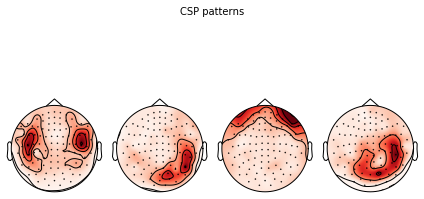

In [5]:
from sklearn.svm import SVC  # noqa
from sklearn.cross_validation import ShuffleSplit  # noqa
from mne.decoding import CSP  # noqa

n_components = 3  # pick some components
svc = SVC(C=1, kernel='linear')
csp = CSP(n_components=n_components)

# Define a monte-carlo cross-validation generator (reduce variance):
cv = ShuffleSplit(len(labels), 10, test_size=0.2, random_state=42)
scores = []
epochs_data = epochs.get_data()

for train_idx, test_idx in cv:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data[train_idx], y_train)
    X_test = csp.transform(epochs_data[test_idx])

    # fit classifier
    svc.fit(X_train, y_train)

    scores.append(svc.score(X_test, y_test))

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))

# Or use much more convenient scikit-learn cross_val_score function using
# a Pipeline
from sklearn.pipeline import Pipeline  # noqa
from sklearn.cross_validation import cross_val_score  # noqa
cv = ShuffleSplit(len(labels), 10, test_size=0.2, random_state=42)
clf = Pipeline([('CSP', csp), ('SVC', svc)])
scores = cross_val_score(clf, epochs_data, labels, cv=cv, n_jobs=1)
print(scores.mean())  # should match results above

# And using reuglarized csp with Ledoit-Wolf estimator
csp = CSP(n_components=n_components, reg='ledoit_wolf')
clf = Pipeline([('CSP', csp), ('SVC', svc)])
scores = cross_val_score(clf, epochs_data, labels, cv=cv, n_jobs=1)
print(scores.mean())  # should get better results than above

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)
data = csp.patterns_
fig, axes = plt.subplots(1, 4)
for idx in range(4):
    mne.viz.plot_topomap(data[idx], evoked.info, axes=axes[idx], show=False)
fig.suptitle('CSP patterns')
fig.tight_layout()
fig.show()

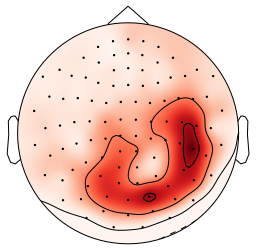

(<matplotlib.image.AxesImage at 0x7f1fa44c1a20>,
 <matplotlib.contour.QuadContourSet at 0x7f1fa41bd0b8>)

In [6]:
mne.viz.plot_topomap(data[3], evoked.info, show=True)

In [7]:
epochs, labels.shape, labels.dtype, data.shape, raw.get_data().shape, data.dtype, evoked.info
# mne.viz.plot_topomap(raw.get_data()[0, :], evoked.info, show=True)

(<Epochs  |  n_events : 145 (all good), tmin : -0.199795213158 (s), tmax : 0.499488032896 (s), baseline : None, ~27.1 MB, data loaded,
  'aud_l': 72, 'vis_l': 73>,
 (145,),
 dtype('>u4'),
 (203, 203),
 (376, 41700),
 dtype('float64'),
 <Info | 19 non-empty fields
    bads : 'list | 0 items
    buffer_size_sec : 'numpy.float64 | 13.3196808772
    ch_names : 'list | MEG 0113, MEG 0112, MEG 0122, MEG 0123, MEG 0132, ...
    chs : 'list | 203 items (GRAD: 203)
    comps : 'list | 0 items
    custom_ref_applied : 'bool | False
    dev_head_t : 'mne.transforms.Transform | 3 items
    dig : 'list | 146 items
    events : 'list | 0 items
    file_id : 'dict | 4 items
    highpass : 'float | 2.0 Hz
    hpi_meas : 'list | 1 items
    hpi_results : 'list | 1 items
    lowpass : 'float | 40.0 Hz
    meas_date : 'numpy.ndarray | 2002-12-03 14:01:10
    meas_id : 'dict | 4 items
    nchan : 'int | 203
    projs : 'list | PCA-v1: on, PCA-v2: on, PCA-v3: on, ...
    sfreq : 'float | 150.15374755859375